In [58]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams
import os
from tqdm import tqdm

In [59]:
EGFR_df = pd.read_csv(os.path.join("..", "2_adme_lead-likeness", "EGFR_lipinski.csv"))

In [60]:
EGFR_df.head()

,passed,Molecular mass,LogP,H-Donors,H-Acceptors,molecule_name,canonical_smiles
0,True,193.199,-3.6059,6,6,CHEMBL2114210,OC[C@H]1N[C@H](CO)[C@@H](O)C(O)[C@@H]1O
1,True,193.199,-3.6059,6,6,CHEMBL2093897,OC[C@@H]1N[C@H](CO)[C@@H](O)[C@H](O)[C@H]1O
2,True,219.281,-1.4543,4,5,CHEMBL77918,CCCCN1[C@H](CO)[C@@H](O)[C@H](O)[C@H]1CO
3,True,163.173,-2.9668,5,5,CHEMBL307429,OC[C@H]1NC[C@H](O)[C@@H](O)[C@@H]1O
4,True,270.240,2.5768,3,5,CHEMBL44,O=c1c(-c2ccc(O)cc2)coc2cc(O)cc(O)c12


<h3>Zdefiniowanie parametrów i katalogu ze związkami PAINS</h3>

In [61]:
params = FilterCatalogParams()
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
catalog = FilterCatalog(params)

<h3>Szukanie związków PAINS w zbiorze danych i usunięcie ich ze zbioru danych</h3>

In [62]:
# search for PAINS
matches = []
clean = []
for index, row in tqdm(EGFR_df.iterrows(), total=EGFR_df.shape[0]):
    molecule = Chem.MolFromSmiles(row['canonical_smiles'])
    entry = catalog.GetFirstMatch(molecule)  # Get the first matching PAINS
    if entry is not None:
        # store PAINS information
        matches.append(
            {
                "chembl_id": row.molecule_name,
                "rdkit_molecule": molecule,
                "pains": entry.GetDescription().capitalize(),
            }
        )
    else:
        # collect indices of molecules without PAINS
        clean.append(index)

matches = pd.DataFrame(matches)
EGFR_df_wo_pains = EGFR_df.loc[clean]  # keep molecules without PAINS

100%|██████████| 25/25 [00:00<00:00, 156.36it/s]


In [63]:
# NBVAL_CHECK_OUTPUT
print(f"Number of compounds with PAINS: {len(matches)}")
print(f"Number of compounds without PAINS: {len(EGFR_df_wo_pains)}")

Number of compounds with PAINS: 2
Number of compounds without PAINS: 23


<h3>Wyświetlenie związków zaklasyfikowanych jako związki PAINS</h3>

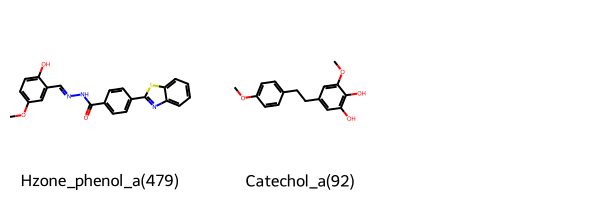

In [64]:
Chem.Draw.MolsToGridImage(
    list(matches.head(2).rdkit_molecule),
    legends=list(matches.head(2)["pains"]),
)

<h3>Wczytanie niechcianych związków z publikacji <i>Brenka et al.(Chem. Med. Chem. 2008, 3, 435-44)</i></h3>

In [65]:
substructures = pd.read_csv("unwanted_substructures.csv", sep=" ")
substructures["rdkit_molecule"] = substructures.smarts.apply(Chem.MolFromSmarts)
print("Number of unwanted substructures in collection:", len(substructures))
# NBVAL_CHECK_OUTPUT

Number of unwanted substructures in collection: 104


<h3>Wyświetlenie przykładowych związków niepożądanych z powyższej publikacji</h3>

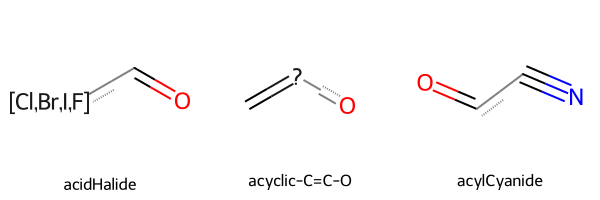

In [66]:
Chem.Draw.MolsToGridImage(
    mols=substructures.rdkit_molecule.tolist()[2:5],
    legends=substructures.name.tolist()[2:5],
)

<h3>Znalezienie i usunięcie niechcianych struktur</h3>

In [67]:
# search for unwanted substructure
matches = []
clean = []
for index, row in tqdm(EGFR_df_wo_pains.iterrows(), total=EGFR_df_wo_pains.shape[0]):
    molecule = Chem.MolFromSmiles(row["canonical_smiles"])
    match = False
    for _, substructure in substructures.iterrows():
        if molecule.HasSubstructMatch(substructure.rdkit_molecule):
            matches.append(
                {
                    "chembl_id": row.molecule_name,
                    "rdkit_molecule": molecule,
                    "substructure": substructure.rdkit_molecule,
                    "substructure_name": substructure["name"],
                }
            )
            match = True
    if not match:
        clean.append(index)

matches = pd.DataFrame(matches)
EGFR_clean = EGFR_df_wo_pains.loc[clean]

100%|██████████| 23/23 [00:00<00:00, 107.13it/s]


<h3>Zapisanie oczyszczonej matrycy do kolejnych zadań</h3>

In [68]:
# EGFR_clean.to_csv("EGFR_clean.csv", index=False)

In [69]:
# NBVAL_CHECK_OUTPUT
print(f"Number of found unwanted substructure: {len(matches)}")
print(f"Number of compounds without unwanted substructure: {len(EGFR_clean)}")

Number of found unwanted substructure: 23
Number of compounds without unwanted substructure: 10


<h3>Wyświetlenie przykładowych niechcianych struktur z powyższej publikacji</h3>

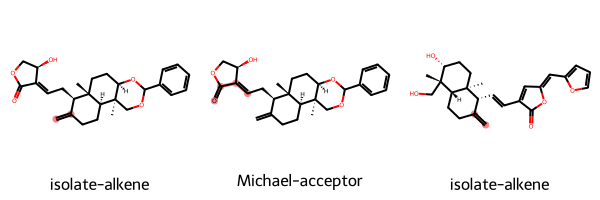

In [70]:
to_highlight = [
    row.rdkit_molecule.GetSubstructMatch(row.substructure) for _, row in matches.head(3).iterrows()
]
Chem.Draw.MolsToGridImage(
    list(matches.head(3).rdkit_molecule),
    highlightAtomLists=to_highlight,
    legends=list(matches.head(3).substructure_name),
)

<h3>Wypisanie częstości występowania podstruktur</h3>

In [71]:
# NBVAL_CHECK_OUTPUT
groups = matches.groupby("substructure_name")
group_frequencies = groups.size()
group_frequencies.sort_values(ascending=False, inplace=True)
group_frequencies.head(10)

substructure_name
isolate-alkene                     6
Michael-acceptor                   5
charged-oxygen/sulfur-atoms        3
cumarine                           2
Sulfonic-acid                      2
sulphate                           2
>2EsterGroups                      1
Polycyclic-aromatic-hydrocarbon    1
Aliphatic-long-chain               1
dtype: int64